In [21]:
import matplotlib.pyplot as plt
import re
import os

def extract_data_from_log(log_filepath):
    """
    Extracts step, loss, and training start markers from a log file.

    Args:
        log_filepath (str): The path to the log file.

    Returns:
        tuple: A tuple containing three lists: (steps, losses, training_start_steps).
               Returns ([], [], []) if the file doesn't exist or no data is found.
    """
    steps = []
    losses = []
    training_start_steps = []
    
    if not os.path.exists(log_filepath):
        print(f"Warning: Log file not found at {log_filepath}")
        return steps, losses, training_start_steps

    found_start_training_signal = False
    with open(log_filepath, 'r') as f:
        for line in f:
            # Check for "Starting training!" message
            if "Starting training!" in line:
                found_start_training_signal = True
            
            # Regex to find "Step: <number> | Loss: <float_number>"
            step_loss_match = re.search(r"Step: (\d+) \| Loss: ([\d\.]+)", line)
            if step_loss_match:
                try:
                    step = int(step_loss_match.group(1))
                    loss = float(step_loss_match.group(2))
                    steps.append(step)
                    losses.append(loss)
                    
                    # If a "Starting training!" signal was just found,
                    # this current step is considered a training start step.
                    if found_start_training_signal:
                        training_start_steps.append(step)
                        found_start_training_signal = False # Reset flag after associating with a step
                except ValueError:
                    print(f"Warning: Could not parse step/loss from line: {line.strip()}")
                    
    return steps, losses, training_start_steps

def plot_single_loss_curve(filepath, title="Loss vs. Step", label=None):
    """
    Plots the loss vs. step for a single log file, including training start markers.

    Why each step is necessary:
    (Additions for vertical lines)
    9. extract_data_from_log(): Now also returns 'training_start_steps'.
    10. Loop through training_start_steps: For each identified start step.
    11. plt.axvline(): Draws a vertical line at the 'start_step'.
        - 'color', 'linestyle' are for visual distinction.
        - 'label' is set for the first vertical line to create a legend entry.
          Subsequent lines for the *same event type* typically don't need a new label
          if they share the same style, as Matplotlib's legend can group them.
          Here, we label it once to ensure it appears.
    """
    plt.figure(figsize=(10, 6))

    steps, losses, training_starts = extract_data_from_log(filepath)

    if not steps or not losses:
        print(f"No data to plot for file: {filepath}")
        plt.title(f"{title} (No data found for {os.path.basename(filepath)})")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()
        return

    plot_label = label if label else os.path.basename(filepath)
    plt.plot(steps, losses, label=plot_label, zorder=2) # Main plot line

    # Plot vertical lines for training starts
    # Label only the first instance of such a line to avoid duplicate legend entries
    # if multiple 'Training Start' events occur.
    vline_label_set = False
    for start_step in training_starts:
        current_label = 'Training Start Event' if not vline_label_set else None
        plt.axvline(x=start_step, color='orangered', linestyle='--', linewidth=1.2, 
                    label=current_label, zorder=1) # Draw behind the main plot line
        if not vline_label_set:
            vline_label_set = True


    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_multiple_loss_curves(file_paths, labels, title="Comparison of Training Losses"):
    """
    Plots loss vs. step for multiple log files on the same graph,
    including common training start markers.

    Why each step is necessary:
    (Additions for vertical lines)
    10. all_training_start_steps = set(): Collects all unique start steps from all files
        to avoid drawing duplicate lines if multiple logs mark the same start step.
    11. Inside loop: Populate all_training_start_steps from each file's training_starts.
    12. After loop: Iterate through sorted unique start steps.
    13. plt.axvline(): Draws each unique vertical line. A single label is used for all
        these event markers in the legend.
    """
    if len(file_paths) != len(labels):
        raise ValueError("The number of file_paths must exactly match the number of labels.")

    plt.figure(figsize=(12, 7))
    
    all_unique_training_start_steps = set()

    for filepath, label in zip(file_paths, labels):
        steps, losses, training_starts = extract_data_from_log(filepath)
        if steps and losses:
            plt.plot(steps, losses, label=label, zorder=2) # Main plot line
            for start_step in training_starts:
                all_unique_training_start_steps.add(start_step)
        else:
            print(f"Warning: No data found or plotted for {filepath} with label '{label}'.")

    # Plot unique vertical lines for all training starts found across files
    # Label only the first instance for the legend.
    vline_label_set = False
    for start_step in sorted(list(all_unique_training_start_steps)): # Sort for consistent order
        current_label = 'Training Start Event' if not vline_label_set else None
        plt.axvline(x=start_step, color='orange', linestyle='--', linewidth=1, 
                    label=current_label, zorder=1) # Draw behind main plot lines
        if not vline_label_set:
             vline_label_set = True

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


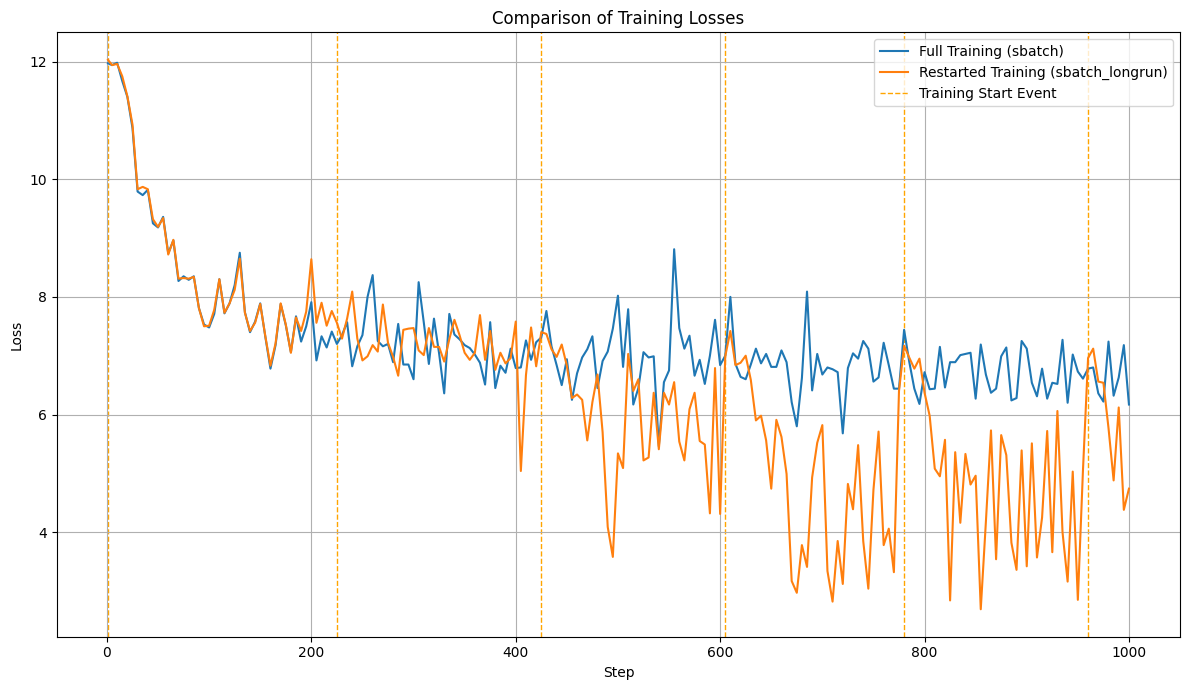

In [23]:
filepaths = ["logs/run_example_assignment2_standard_sbatch.err", "logs/run_example_assignment2.err"]
labels = ["Full Training (sbatch)", "Restarted Training (sbatch_longrun)"]
plot_multiple_loss_curves(filepaths, labels, title="Comparison of Training Losses")